# Data Preprocessing and Model Building

In [1]:


import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report


from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



### **1-Data Preprocessing**

#### Loading data

In [2]:

df = pd.read_csv("books.csv", sep=",",on_bad_lines="skip")
df_enrichement=pd.read_csv("data_enrichement2.csv", sep=",",on_bad_lines="skip")

#### Preprocessing the orignal Dataset

In [3]:
df.rename(columns={df.columns[7]:"num_pages"},inplace=True)

df['average_rating'] = df['average_rating'].round().astype("int64") 


def extract_month_year_from_date(date_str):
    try:
        # Try to convert to datetime
        date_obj = pd.to_datetime(date_str)
        return date_obj.month, date_obj.year
    except ValueError:
        # If error, use string extraction
        parts = date_str.split('/')
        if len(parts) != 3:
            return None, None
        month, _, year = parts
        return int(month), int(year)

df.loc[::,'publication_month'], df.loc[::,'publication_year'] = zip(*df.loc[::,'publication_date'].apply(extract_month_year_from_date))
df=df.drop(columns="publication_date")

#### Merging and cleaning Dataframes 

In [4]:
df_merged=pd.concat([df,df_enrichement]).reset_index(drop=True)

In [5]:
df_merged=df_merged.replace(" ",pd.NA)
df_merged=df_merged.dropna()

In [6]:
df_merged= df_merged.drop_duplicates(subset="isbn")


In [7]:
authors_df=pd.read_json("goodreads_book_authors.json", lines=True)

In [8]:
authors_df.rename(columns={authors_df.columns[3]:"name"},inplace=True)
df_merged['authors'] = df_merged['authors'].str.split('/').str[0]
df_merged['authors'] = df_merged['authors'].str.split(',').str[0]

In [9]:
# Merge the average_rating of authors into df_merged
df_merged = pd.merge(df_merged, authors_df[['name', 'average_rating']], left_on='authors', right_on='name', how='left', suffixes=('', '_author'))


In [10]:
df_merged["average_rating_author"] = df_merged["average_rating_author"].fillna(df_merged["average_rating_author"].mean())
df_merged['average_rating_author'] = df_merged['average_rating_author'].round().astype("int64")


In [11]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20169 entries, 0 to 20168
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bookID                 20169 non-null  int64  
 1   title                  20169 non-null  object 
 2   authors                20169 non-null  object 
 3   average_rating         20169 non-null  int64  
 4   isbn                   20169 non-null  object 
 5   isbn13                 20169 non-null  object 
 6   language_code          20169 non-null  object 
 7   num_pages              20169 non-null  int64  
 8   ratings_count          20169 non-null  int64  
 9   text_reviews_count     20169 non-null  int64  
 10  publisher              20169 non-null  object 
 11  publication_month      20169 non-null  float64
 12  publication_year       20169 non-null  int64  
 13  name                   19593 non-null  object 
 14  average_rating_author  20169 non-null  int64  
dtypes:

In [12]:
df_merged[df_merged.average_rating_author.isna()]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publisher,publication_month,publication_year,name,average_rating_author


In [13]:
#dropping useless columns
df_merged=df_merged.drop(columns=["isbn","isbn13","bookID"])


df_merged =df_merged[df_merged.ratings_count!=0]
df_merged =df_merged[df_merged.num_pages!=0]


df_merged.loc[::,'language_code'] = df_merged.loc[::,'language_code'].str.replace(r'^en.*', 'eng')



C:\Users\farou\AppData\Local\Temp\ipykernel_1508\569322010.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_merged.loc[::,'language_code'] = df_merged.loc[::,'language_code'].str.replace(r'^en.*', 'eng')


In [14]:
def group(df,index,values,sort):
    table = df.copy().groupby(index).agg(values)
    return table.sort_values(by=sort,ascending=False).reset_index()


In [15]:
group(df_merged,"average_rating",{"text_reviews_count":"mean","ratings_count":"mean",'num_pages':"mean","title":"count"},"title")

,average_rating,text_reviews_count,ratings_count,num_pages,title
0,4,576.266860,18833.647440,341.229179,10350
1,3,77.912032,1225.481294,287.317240,3956
2,5,48.677564,1696.447139,319.321118,3793
3,2,6.210495,48.393868,47.069575,1696
4,1,2.797980,4.126263,4.828283,198


#### Feature engineering

**Label encode Title, authors and publisher columns**

In [16]:


le = LabelEncoder()
df_merged['title'] = le.fit_transform(df_merged['title'])
df_merged['authors'] = le.fit_transform(df_merged['authors'])
df_merged['publisher'] = le.fit_transform(df_merged['publisher'])

In [17]:
df_merged.publisher.unique()

array([4846, 4840, 3840, ..., 2209, 4511, 2574])

**Creating 4 classes for average_rating**

In [18]:

bins = [ -1, 2, 3, 4, 5]  # 0 is used to ensure 1 is included in the first bin
labels = ['bad', 'average', 'good', 'very good']

# Create a new column with the binned values
df_merged['binned_rating'] = pd.cut(df_merged['average_rating'], bins=bins, labels=labels,right=True)

**Feature selection**

In [19]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif

X = df_merged.drop(columns=["binned_rating",'average_rating',"language_code","name"])
y = df_merged['binned_rating']

#selector = SelectKBest(f_regression, k='all').fit(X, y)

selector = SelectKBest(mutual_info_classif, k='all').fit(X, y)

scores = selector.scores_
scores

array([0.12114024, 0.26156414, 0.44505944, 0.3147422 , 0.23966414,
       0.338818  , 0.00464273, 0.36866527, 0.32175628])

In [20]:
X.columns

Index(['title', 'authors', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publisher', 'publication_month', 'publication_year',
       'average_rating_author'],
      dtype='object')

In [21]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19993 entries, 0 to 20168
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   title                  19993 non-null  int32   
 1   authors                19993 non-null  int32   
 2   average_rating         19993 non-null  int64   
 3   language_code          19993 non-null  object  
 4   num_pages              19993 non-null  int64   
 5   ratings_count          19993 non-null  int64   
 6   text_reviews_count     19993 non-null  int64   
 7   publisher              19993 non-null  int32   
 8   publication_month      19993 non-null  float64 
 9   publication_year       19993 non-null  int64   
 10  name                   19444 non-null  object  
 11  average_rating_author  19993 non-null  int64   
 12  binned_rating          19993 non-null  category
dtypes: category(1), float64(1), int32(3), int64(6), object(2)
memory usage: 1.8+ MB


**One hot encoding the language_code column**

In [22]:
dummies = pd.get_dummies(df_merged['language_code'], prefix='lang')

# Concatenate the dummies DataFrame to the original df
df_merged = pd.concat([df_merged, dummies], axis=1)



**Data Splitting and augmentation**

In [23]:
from sklearn.model_selection import train_test_split

In [24]:

df_train, df_test = train_test_split(df_merged,test_size = 0.2)
# get the values of the columns for the training data

X_train = df_train.drop(columns=["average_rating","language_code","binned_rating",'lang_--','name']).values
y_train = df_train.binned_rating.values


#get the values of the columns for the test data
X_test = df_test.drop(columns=["binned_rating","average_rating","language_code",'lang_--','name']).values
y_test = df_test.binned_rating.values


Over-sampling minority class

In [25]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) 

**Feature scaling**

In [26]:
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_smote)
X_test_knn = scaler.transform(X_test)


### **2. Model training**

#### Trying multiple models

Random Forest

In [27]:
RF = RandomForestClassifier()


RF.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_RF = RF.predict(X_test)
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

     average       0.72      0.62      0.66       825
         bad       0.70      0.76      0.73       379
        good       0.92      0.97      0.94      2039
   very good       0.82      0.79      0.81       756

    accuracy                           0.84      3999
   macro avg       0.79      0.78      0.78      3999
weighted avg       0.84      0.84      0.84      3999



Decision Tree

In [28]:
DT=DecisionTreeClassifier()
DT.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_DT = DT.predict(X_test)






In [29]:
print("decision_tree",classification_report(y_test, y_pred_DT))

decision_tree               precision    recall  f1-score   support

     average       0.51      0.51      0.51       825
         bad       0.59      0.68      0.63       379
        good       0.91      0.88      0.90      2039
   very good       0.68      0.69      0.69       756

    accuracy                           0.75      3999
   macro avg       0.67      0.69      0.68      3999
weighted avg       0.76      0.75      0.75      3999



KNN

In [30]:
KNN=KNeighborsClassifier()
KNN.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_KNN = KNN.predict(X_test)


c:\Users\farou\.conda\envs\production\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [31]:
print("KNN",classification_report(y_test, y_pred_KNN))

KNN               precision    recall  f1-score   support

     average       0.30      0.38      0.34       825
         bad       0.19      0.36      0.25       379
        good       0.86      0.63      0.73      2039
   very good       0.37      0.36      0.36       756

    accuracy                           0.50      3999
   macro avg       0.43      0.43      0.42      3999
weighted avg       0.59      0.50      0.53      3999



#### Tuning hyperparameters for the best models

Decision tree : second best model

In [32]:
# Decision Tree GridSearch
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier()
dt_gs = GridSearchCV(dt, dt_params, cv=5, n_jobs=-1)
dt_gs.fit(X_train_smote, y_train_smote)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [33]:
# Fit the model with best parameters
dt_best = dt_gs.best_estimator_
dt_best.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_dt = dt_best.predict(X_test)
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

     average       0.65      0.60      0.62       825
         bad       0.67      0.76      0.71       379
        good       0.91      0.95      0.93      2039
   very good       0.82      0.74      0.78       756

    accuracy                           0.82      3999
   macro avg       0.76      0.76      0.76      3999
weighted avg       0.82      0.82      0.82      3999



Random Forest : **Best model**

In [34]:

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}






rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)


Fitting 3 folds for each of 180 candidates, totalling 540 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy', verbose=2)

In [35]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred_rf = best_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

     average       0.71      0.62      0.66       825
         bad       0.70      0.77      0.73       379
        good       0.91      0.97      0.94      2039
   very good       0.83      0.78      0.80       756

    accuracy                           0.84      3999
   macro avg       0.79      0.78      0.78      3999
weighted avg       0.84      0.84      0.84      3999



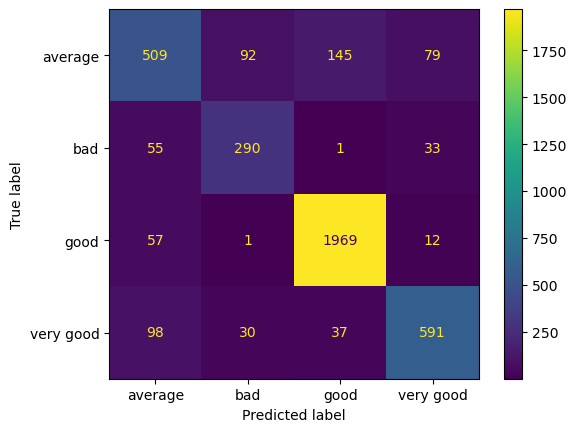

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix,display_labels=["average", "bad", "good", "very good"])
conf_matrix_display.plot()